# RNN 활용 텍스트 분석

> imdb 영화 리뷰 데이터셋(영문)

## 텍스트 분석을 위해 개선된 알고리즘의 종류

### [1] RNN

- Embedding층은 단순하게 데이터의 표현을 학습하여 데이터 사전을 구축하는 것
- 하지만 유사한 의미의 단어를 비슷한 공간에 매핑할 수 있지만, 시퀀스 데이터의 중요한 특성인 순서와 맥락까지 고려한 것은 아니다.
- 순환 신경망은 이 문제를 해결하기 위해 고안된 층
- 컨볼루션 신경망의 반대되는 개념.

### [2] LSTM

- RNN의 그래디언트 손실문제를 보완한 방법
- 정보를 여러 시점에 걸쳐 나르는 장치(‘Cell state’)가 추가되었다.
- 이로 인해 그래디언트를 보존할 수 있어 그래디언트 손실 문제가 발생하지 않도록 도와준다.

### [3] GRU

- 게이트 메커니즘이 적용된 RNN의 일종으로 LSTM에서 영감을 받았으며 더 간략한 구조를 갖는다.
- 한국인 조경현 박사님이 제안한 방법

> 이전 예제에서 학습 모델을 정의과정의 알고리즘만 변경하면 되기 때문에 큰 맥락은 앞 예제와 동일하다. 학습 시간이 매우 오래 걸리는 예제이므로 가급적 GPU가 탑재된 컴퓨터에서 실습하는 것이 좋다.

## #01. 준비작업

### [1] 패키지 참조


In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from helper.util import *
from helper.plot import *
from helper.tensor import *

# 순수 Tensorflow 코드로 구현하고자 할 경우 아래 구문이 필요함
#from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN, LSTM, GRU

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

Tensorflow에 내장된 데이터가 있지만, 동일 데이터를 미리 엑셀로 저장 두었다.


In [2]:
origin = my_read_excel(
    "https://data.hossam.kr/tmdata/imdb.xlsx", categories=["sentiment"], info = False
)

## #02. 데이터 전처리

### [1] 종속변수 라벨링


In [3]:
df = my_labelling(origin, "sentiment")
my_pretty_table(df.head(10))

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [2] 문자열 전처리

* 축약형 문자열 처리
* 이메일 주소 제거
* HTML 태그 제거
* URL 제거
* 숫자 제거
* 특수문자 제거
* 불용어 제거

#### (1) 영어 불용어 목록


In [4]:
stopwords = my_stopwords("en")
stopwords[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

#### (2) 전처리 수행


In [5]:
%%time

df2 = my_text_data_preprocessing(df, "review", rm_abbr=True, rm_email=True, rm_html=True, rm_url=True, rm_num = True, rm_special=True, stopwords=stopwords)
my_pretty_table(df2.head(10))

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [3] 문자열 토큰화 및 패딩

In [6]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from helper.util import *
from helper.plot import *
from helper.tensor import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%%time

df3, token_set, vocab_size = my_token_process(df2, xname='review', yname='sentiment', threshold=30, max_word_count=None) # max_word_count를 None으로 제한하면 최대단어수로 적용

print("vocab_size:", vocab_size)

max_word_count = df3['count'].max()
print("max_word_count:", max_word_count)

df3

단어 집합(vocabulary)의 크기 : 216418
등장 빈도가 30번 미만인 희귀 단어의 수: 201100
단어 집합에서 희귀 단어의 비율: 92.92203051502186
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.597505256648489
단어 집합의 크기 : 15319
독립변수(텍스트) 데이터 수:  49998
종속변수(레이블) 데이터 수:  49998
vocab_size: 15319
max_word_count: 1508
CPU times: total: 11.9 s
Wall time: 12 s


,sentiment,text,count,token,pad_token
0,1,One reviewers mentioned watching Oz episode ho...,181,"[7, 1855, 991, 76, 3228, 322, 3066, 71, 124, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,A wonderful little production The filming tech...,94,"[53, 315, 51, 289, 4, 1277, 2901, 1, 1, 1545, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,I thought wonderful way spend time hot summer ...,93,"[2, 114, 315, 35, 1037, 14, 828, 1398, 2392, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,Basically there is family little boy Jake thin...,72,"[615, 26, 8, 157, 51, 368, 3518, 1117, 26, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,Petter Matteis Love Time Money visually stunni...,130,"[1, 1, 47, 14, 216, 2067, 1292, 5, 39, 379, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
49993,1,I thought movie right good job It creative ori...,98,"[2, 114, 3, 124, 11, 217, 6, 1391, 125, 27, 91...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49994,0,Bad plot bad dialogue bad acting idiotic direc...,62,"[22, 49, 22, 336, 22, 48, 2899, 892, 558, 1475...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49995,0,I Catholic taught parochial elementary schools...,122,"[2, 3437, 4166, 1, 8213, 4417, 8662, 4166, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49996,0,I am going disagree previous comment side Malt...,120,"[2, 64, 80, 2897, 814, 845, 430, 11388, 7, 10,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## #04. 학습 모형 적합

### [2] 데이터 분할


In [8]:
x_train, x_test, y_train, y_test = my_train_test_split(token_set, ydata=df3['sentiment'])

print(
    "훈련용 데이터셋 크기: %s, 검증용 데이터셋 크기: %s" % (x_train.shape, x_test.shape)
)
print("훈련용 레이블 크기: %s, 검증용 레이블 크기: %s" % (y_train.shape, y_test.shape))

훈련용 데이터셋 크기: (39998, 1508), 검증용 데이터셋 크기: (10000, 1508)
훈련용 레이블 크기: (39998,), 검증용 레이블 크기: (10000,)


### [3] 모델 생성

dropout은 지정된 비율만큼 학습을 건너뛰게 하는 파라미터. 이 파라미터를 사용하게 되면 과거 학습정보를 잃어버릴 확률이 높아지고 그에 따라 모델 성능이 나빠질 가능성이 있다.

recurrent_dropout(순환드롭아웃)은 과거 학습정보를 잃어버리는 문제를 해결하기 위해 적용하는 옵션.


{'type': 'embedding', 'input_dim': 15319, 'output_dim': 32, 'input_length': 1508}
{'type': 'rnn', 'units': 32, 'return_sequences': True, 'dropout': 0.15, 'recurrent_dropout': 0.15}
{'type': 'rnn', 'units': 16}
{'type': 'flatten'}
{'type': 'dense', 'units': 1, 'activation': 'sigmoid'}


0epoch [00:00, ?epoch/s]

+-------+----------+----------+
|       |      acc |     loss |
|-------+----------+----------|
| train | 0.876469 | 0.314759 |
| test  |   0.8283 | 0.400434 |
+-------+----------+----------+


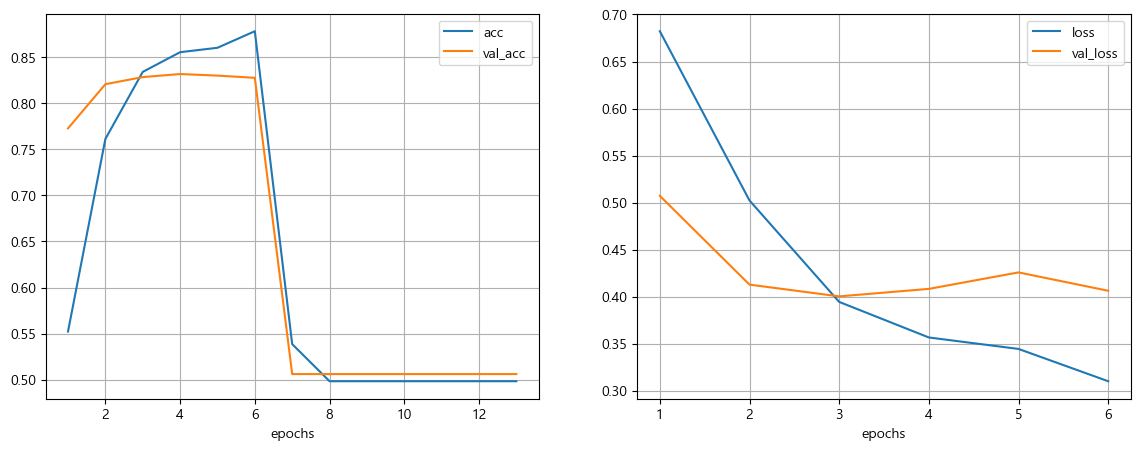

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1508, 32)       │       490,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 1508, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,479,269 (5.64 MB)

 Trainable params: 493,089 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 986,180 (3.76 MB)

CPU times: total: 4h 34min 44s
Wall time: 1h 49min 19s


In [9]:
%%time

# model = Sequential()
# model.add(Embedding(input_dim = vocab_size, output_dim = 32, input_length = max_word_count))
# model.add(SimpleRNN(32, return_sequences=True, dropout=0.15, recurrent_dropout=0.15)) # embed 층에서 output한 층의 수를 적어야함
# model.add(SimpleRNN(16))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['acc'])
# model.summary()

model = my_tf(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    layer=[
        dict(type="embedding", input_dim=vocab_size, output_dim=32, input_length=max_word_count),
        dict(type="rnn", units=32, return_sequences=True, dropout=0.15, recurrent_dropout=0.15),
        dict(type="rnn", units=16),
        dict(type="flatten"),
        dict(type="dense", units=1, activation="sigmoid")
    ],
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["acc"]
)

model.summary()

## #06. 학습 결과 적용

### [1] 검증 데이터에 대한 예측 결과 산정


In [10]:
result = model.predict(x_test)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step
10000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[0.9124583 ],
       [0.79381895],
       [0.9348834 ],
       ...,
       [0.1392679 ],
       [0.13128355],
       [0.1511411 ]], dtype=float32)

### [2] 예측 결과를 1차원 배열로 변환


In [11]:
f_results = result.flatten()
f_results = np.round(f_results, 0)
f_results

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

### [3] 오차행렬


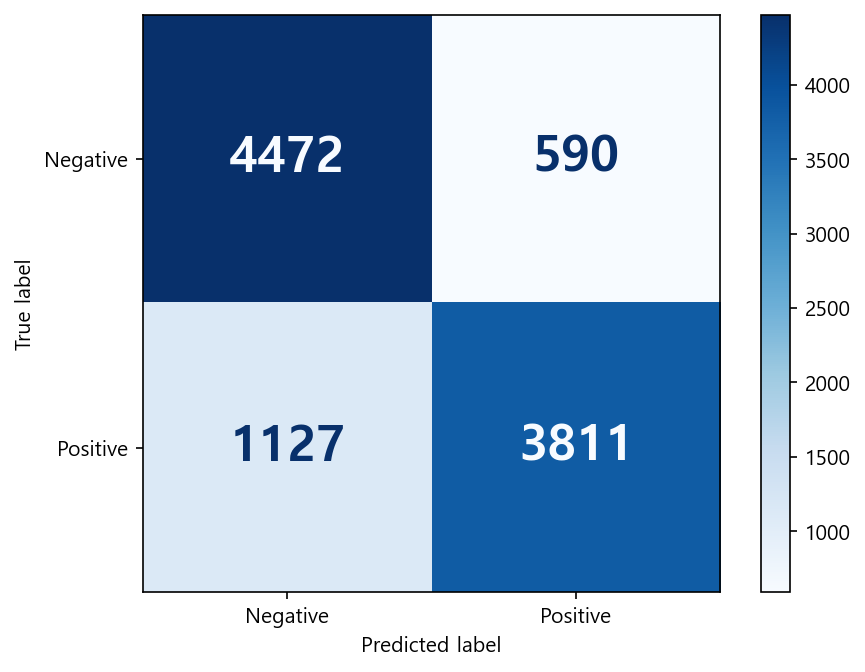

In [12]:
my_confusion_matrix(y=y_test, y_pred=f_results, figsize=(7, 5))

## #07. 학습 결과 활용

### [1] 임의의 문장


In [13]:
review = [
    "I had a lot of fun watching it.",
    "I didn't notice how time passed.",
    "I was happy the whole time I watched it.",
    "worst movie",
    "such a boring movie",
]

### [2] 문자열 전처리


In [14]:
review_pre = [my_text_preprocessing(x, stopwords=stopwords) for x in review]
review_pre

['I lot fun watching it',
 'I notice time passed',
 'I happy whole time I watched it',
 'worst movie',
 'boring movie']

### [3] 토큰화 + 패딩


In [15]:
_, token_set, _ = my_token_process(review_pre, num_words=vocab_size, max_word_count=max_word_count)
token_set

단어 집합(vocabulary)의 크기 : 15
등장 빈도가 10번 미만인 희귀 단어의 수: 14
단어 집합에서 희귀 단어의 비율: 93.33333333333333
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 100.0
단어 집합의 크기 : 2
독립변수(텍스트) 데이터 수:  5


array([[ 0,  0,  0, ...,  7,  8,  3],
       [ 0,  0,  0, ...,  9,  4, 10],
       [ 0,  0,  0, ...,  2, 13,  3],
       [ 0,  0,  0, ...,  0, 14,  5],
       [ 0,  0,  0, ...,  0, 15,  5]])

### [5] 예측값 생성


In [16]:
f_results = model.predict(token_set)
data_count, case_count = f_results.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
f_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
5개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[0.1310281 ],
       [0.09922745],
       [0.10504012],
       [0.1022363 ],
       [0.09953043]], dtype=float32)

### [6] 결과 판정


In [17]:
f_results = np.round(f_results.flatten(), 0)

for i, v in enumerate(review):
    k = "긍정" if f_results[i] == 1 else "부정"
    print(f"[{k}] {v}")

[부정] I had a lot of fun watching it.
[부정] I didn't notice how time passed.
[부정] I was happy the whole time I watched it.
[부정] worst movie
[부정] such a boring movie
